In [1]:
%pylab inline
import cv2
import numpy as np
import logging
import math
import csv

Populating the interactive namespace from numpy and matplotlib


### Display Methods

In [2]:
def display_frame(cap, index):
    ''' Display a frame from a video capture stream. '''
    frame = get_frame(cap, index)
    display_image(frame)

In [3]:
def display_image(image):
    ''' Show an image in a matplotlib figure. '''
    # If colored, swap color order to RGB
    if len(image.shape) > 2:
        image = image[:,:,[2,1,0]]
        imshow(image)
    else:
        imshow(image, cmap=cm.Greys)

In [4]:
def image_rows(images, ncols=4):
    matrix = []
    for i in xrange(0, len(images), ncols):
        matrix.append(images[i:i+ncols])
    image_matrix(matrix)

In [5]:
def image_matrix(images, imgsize=(8, 5)):
    ''' Show matrix of images of variable size. '''
    if len(images) == 0 or len(images[0]) == 0:
        return
    rows = len(images)
    cols = len(images[0])
    w, h = imgsize
    figure(figsize=(w * cols, h * rows))
    for r, row in enumerate(images):
        for c, img in enumerate(row):
            spn = r * cols + c + 1
            subplot(rows, cols, spn)
            display_image(img)

In [6]:
def draw_rectangle(image, rect):
    ''' Draw a rectangle on an image. '''
    l, t, w, h = rect
    cv2.rectangle(image, 
        (l, t),
        (l + w, t + h), 
        (0, 255, 0), 10)

### Video Stream Methods

In [7]:
''' Helpers for fetching specific frames. '''
get_findex = lambda cap : int(cap.get(cv2.cv.CV_CAP_PROP_POS_FRAMES))
set_findex = lambda cap, f : cap.set(cv2.cv.CV_CAP_PROP_POS_FRAMES, f)

In [8]:
def get_frame(cap, index):
    ''' Modified from code on SO question, "How to process images of a video, frame 
        by frame in video streaming using Opencv python "'''
    
    set_findex(cap, index)    
    logging.debug("Fetching frame %d", index)

    while True:
        flag, frame = cap.read()    
        if flag:
            logging.debug("Got frame %d", index)
            return frame
            break
        else:
            logging.debug("Frame %d not ready, trying again", findex)
            # The frame number increments after a read attempt.
            # Furthermore, to try to read frame i, we set frame number to i + 1.
            # I don't know why, but this is just how the API works.
            index = get_findex(cap)
            set_findex(cap, index)
            cv2.waitKey(500)

# Main Tests

###Preparation

Load video streams (make sure you're in the right directory, and check for possible warnings)

In [9]:
video_paths = [
    'videos/1-vXcC533_IcQ-Android_-_Eclipse_-_02_-_Creating_a_Custom_Splash_Screen_-_Tutorial.mp4',
    'videos/2--MBS2YvUY2M-Android_Facebook_Login_integration_with_Eclipse..mp4',
    'videos/3-p9KRJoX13vo-Android_Development_Tutorial_-_How_To_Make_an_App_and_Run_It_In_The_Emulator.mp4',
    'videos/4-o1vRJ07KDZ0-Android_tutorial_make_android_calculator_app_video_how_to_create_a_calculator_in_android_shashank_ku.mp4',
    'videos/5-ok8mZW_BDG4-Eclipse_Java_Hello_World_Introduction_Tutorial.mp4'
]
streams = [cv2.VideoCapture(p) for p in video_paths]

Open up test data

In [10]:
# Frame rate corrections for where QuickTime's perceived FPS
# is different than what OpenCV reads in
# Also, we found extracted rectangle positions from smaller images than the
# actual video feed, so we have to scale them back up
fcorr = {
    1: 29.41176470588235 / 29.970030,
}
scorr = {
    1: (852.0/639, 480.0/360),
    2: (854.0/641, 460.0/345),
    3: (854.0/588, 480.0/330),
    4: (854.0/608, 464.0/330),
    5: (768.0/576, 480.0/360),
}

In [11]:
with open('rectangles.csv') as datafile:
    data = csv.DictReader(datafile, )
    records = []
    for r in data:
        records.append(r)

In [12]:
events = []

for r in records:

    # Get video and frame index
    vindex = int(r['Vindex'])
    frame_index = int(int(r['Frame']) * fcorr.get(vindex, 1))

    # Load up rectangle data
    xcorr, ycorr = scorr.get(vindex, 1)    
    x, w = [int(int(d) * xcorr) for d in (r['x'], r['w'])]
    y, h = [int(int(d) * ycorr) for d in (r['y'], r['h'])]
    
    # Store as more readable event dictionary
    event = {
        'stream_index': vindex - 1,
        'frame_index': frame_index,
        'rect': (x, y, w, h),
    }
    events.append(event)

Show the frames and menu regions from the test data

In [13]:
frames = []
for e in events: 
    f = get_frame(streams[e['stream_index']], e['frame_index'])
    x,y,w,h = e['rect']
    cv2.rectangle(f, (x,y), (x+w,y+h), (0,128,0), 10)
    frames.append(f)
#image_rows(frames, ncols=5)

### Extracting Menus from Video

#### Image Processing Methods

In [14]:
def recent_diff(cap, fend, frames_before=10):
    '''
    Get a smooth difference in pixels leading up to a frame.
    Adds up the differences from a sequence of earlier frames 
    and 'normalizing' based on the largest difference
    found.  Cancels out some noise from a single image difference.
    '''
    frame_shape = get_frame(cap, fend).shape
    diff = np.zeros(frame_shape, dtype='uint32')
    for f in range(fend - frames_before, fend + 1):
        f1 = get_frame(cap, f)
        f2 = get_frame(cap, f + 1)
        diff += (f2 - f1)
    
    diff_norm = diff * (255.0 / np.max(diff))
    diff_norm = diff_norm.astype('uint8')
    return diff_norm

In [15]:
def blur_image(image, ksize=(15,15), sigma=7):
    return cv2.GaussianBlur(image, ksize, sigma)

In [16]:
def binarize(image, threshold=30):
    _, binarized = cv2.threshold(image.copy(), threshold, 255, cv2.THRESH_BINARY)
    scaled = binarized
    return scaled

In [17]:
def get_contours(image, minarea=5000):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = filter(lambda c: cv2.contourArea(c) > 5000, contours)
    return contours

In [18]:
to_rgb = lambda img: cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
to_grey = lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

Extract differences leading up to each of the frames, show with the expected bounding box

In [19]:
diffs = []
diff_images = []
for e in events:
    stream = streams[e['stream_index']]
    diff = recent_diff(stream, e['frame_index'])
    x,y,w,h = e['rect']
    diff_image = diff.copy()
    cv2.rectangle(diff_image, (x,y), (x+w,y+h), (0,128,0), 10)
    diffs.append(diff)
    diff_images.append(diff_image)
#image_rows(diff_images, ncols=5)

Get the bounding rectangles of regions where a difference was found

In [20]:
images = []
blurred_images = []
binarized_images = []
image_contours = []
image_rects = []

In [21]:
for i, e in enumerate(events):
    
    stream_index = e['stream_index']
    frame_index = e['frame_index']
    stream = streams[stream_index]
    image = get_frame(stream, frame_index)
    
    # Get contours for image
    blurred = blur_image(to_grey(diffs[i]))
    binarized = binarize(blurred)
    contours = get_contours(binarized)
    rects = [cv2.boundingRect(c) for c in contours]
    
    images.append(image)
    blurred_images.append(blurred)
    binarized_images.append(binarized)
    image_contours.append(contours)
    image_rects.append(rects)

Show decision process for selecting menu regions from frame differences

In [22]:
matrix = []

for i, e in enumerate(events):
    
    # Draw contours on top of differences
    diff = diffs[i]
    contour_image = diff.copy()
    cv2.drawContours(contour_image, image_contours[i], -1, (255,255,0), 5)
    
    # Draw rectangles on top of differences
    rect_image = diff.copy()
    for r in image_rects[i]:
        x, y, w, h = r
        cv2.rectangle(rect_image, (x, y), (x + w, y + h), (0,0,255), 5)
        
    # Put all into a matrix for us to display
    matrix.append([
        images[i],
        diffs[i],
        to_rgb(blurred_images[i]),
        to_rgb(binarized_images[i] * 255),
        contour_image,
        rect_image,
    ])

#image_matrix(matrix)

Show the regions that we extracted from the video

In [23]:
matrix = []
for i, e in enumerate(events):
    image = images[i].copy()
    for r in image_rects[i]:
        x, y, w, h = r
        image_with_region = image.copy()
        cv2.rectangle(image_with_region, (x, y), (x + w, y + h), (0,0,255), 5)
        matrix.append([
            image,
            image_with_region,
            image[y:y+h,x:x+w,:]
        ])
#image_matrix(matrix)

Compute accuracy of matches

In [24]:
def iou(expected, observed):
    
    ex, ey, ew, eh = expected
    ox, oy, ow, oh = observed
    
    il = max(ex, ox)
    ir = min(ex + ew, ox + ow)
    it = max(ey, oy)
    ib = min(ey + eh, oy + oh)
    ir = il if ir < il else ir
    ib = it if ib < it else ib
    intersection_area = (ir - il) * (ib - it)
    
    union_area = ew * eh + ow * oh - intersection_area
    return intersection_area / float(union_area)

In [25]:
ious = []
matches = []

for i, e in enumerate(events):
    best_iou = 0
    for r in image_rects[i]:
        score = iou(e['rect'], r)
        best_iou = score if score > best_iou else best_iou
    matches.append(True if best_iou > 0 else False)
    ious.append(best_iou)

In [26]:
print ""
print "===========OVERALL RESULTS============"
print ""

correct = sum(matches)
total = len(matches)
print "Found matching windows for %d/%d test frames (%2.f%%)" % (correct, total, 100*float(correct)/total)

valid_ious = [i*100 for i in ious if i > 0]
print "Avg IoU for matches: %2.f%%" % (average(valid_ious))

rect_counts = [len(r) for r in image_rects]
false_positives = sum(map(lambda x: max(0, x-1), rect_counts))
print "Avg false positives per image: %f" % (float(false_positives) / len(images))

print ""


===========OVERALL RESULTS============

Found matching windows for 29/33 test frames (88%)
Avg IoU for matches: 70%
Avg false positives per image: 0.060606



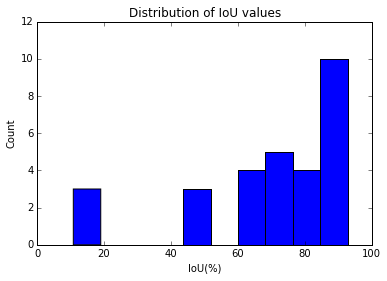

In [27]:
counts, _, _ = hist(valid_ious)
ylim(0, 1.2*max(counts))
xlim(0, 100)
xlabel("IoU(%)")
ylabel("Count")
title("Distribution of IoU values")

# Tesseract-OCR

Now try to get some OCR working. This will create several output images. Make sure you have tesseract installed (use "brew install tesseract"). I have version 3.02.

In [56]:
import subprocess
for i in range(len(matrix)):
    num = "{0:02d}".format(i)
    cv2.imwrite('Images/image_' + num + '.png', matrix[i][0])
    command = "tesseract Images/image_" + num + ".png Images/out_" + num
    subprocess.call(command.split())

The results, um, leave a lot to be desired. Check out the out_i.txt files and compare that with the original image. But at least for the video with the captions, the OCR captures the captions themselves. Now let's try to see how it works with the exracted regions we developed:

In [58]:
for i in range(len(matrix)):
    num = "{0:02d}".format(i)
    cv2.imwrite('Images/image_cropped' + num + '.png', matrix[i][2])
    command = "tesseract Images/image_cropped" + num + ".png Images/out_cropped" + num
    subprocess.call(command.split())

Yeah, it's kind of disappointing.